# Домашнее задание по деревьям принятия решений
Задача кредитного скоринга - одна из наиболее популярных областей, где применяются алгоритмы машинного обучения.<br>
Здесь мы будет прогнозировать, что человек просрочит выплаты по кредиту на 3 месяца и более (целевой признак - Delinquent90).<br>
В качестве метрики была выбрана AUC (Area Under Curve).

Признаки клиентов банка:
- Age - возраст (вещественный)
- Income - месячный доход (вещественный)
- BalanceToCreditLimit - отношение баланса на кредитной карте к лимиту по кредиту (вещественный)
- DIR - Debt-to-income Ratio (вещественный)
- NumLoans - число заемов и кредитных линий
- NumRealEstateLoans - число ипотек и заемов, связанных с недвижимостью (натуральное число)
- NumDependents - число членов семьи, которых содержит клиент, исключая самого клиента (натуральное число)
- Num30-59Delinquencies - число просрочек выплат по кредиту от 30 до 59 дней (натуральное число)
- Num60-89Delinquencies - число просрочек выплат по кредиту от 60 до 89 дней (натуральное число)
- Delinquent90 - были ли просрочки выплат по кредиту более 90 дней (бинарный) - имеется только в обучающей выборке

## 1. Обучение дерева принятия решений
## 1.1 Подгрузка библиотек и инициализация вспомогательных функций

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve

# функция, выдающая базовые метрики классификации
def quality_report(prediction, actual):
    print("Accuracy: {:.3f}\nPrecision: {:.3f}\nRecall: {:.3f}\nf1_score: {:.3f}".format(
        accuracy_score(prediction, actual),
        precision_score(prediction, actual),
        recall_score(prediction, actual),
        f1_score(prediction, actual)
    ))
    
# функция для отрисовки roc-кривой и подсчёта 
def plot_roc_curve(prob_prediction, actual):
    fpr, tpr, thresholds = roc_curve(y_val, prob_prediction)
    auc_score = roc_auc_score(y_val, prob_prediction)
    
    plt.plot(fpr, tpr, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC: {:.3f}'.format(auc_score))
    plt.show()

## 1.2 Загрузка данных

In [3]:
train_df = pd.read_csv('credit_scoring_train.csv', index_col='client_id')
test_df = pd.read_csv('credit_scoring_test.csv', index_col='client_id')

In [4]:
# размер тренировочного набора
train_df.shape

(75000, 10)

In [5]:
# бегло вглянем на данные в тренировочном наборе
train_df.head()

,DIR,Age,NumLoans,NumRealEstateLoans,NumDependents,Num30-59Delinquencies,Num60-89Delinquencies,Income,BalanceToCreditLimit,Delinquent90
client_id,,,,,,,,,,
0,0.496289,49.1,13,0,0.0,2,0,5298.360639,0.387028,0
1,0.433567,48.0,9,2,2.0,1,0,6008.056256,0.234679,0
2,2206.731199,55.5,21,1,NaN,1,0,NaN,0.348227,0
3,886.132793,55.3,3,0,0.0,0,0,NaN,0.971930,0
4,0.000000,52.3,1,0,0.0,0,0,2504.613105,1.004350,0


В данных наблюдаются пропуски. Необходимо посчитать для каждого признака, сколько информации утеряно, и принять решение о методе обработки пропущенных значений.

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75000 entries, 0 to 74999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   DIR                    75000 non-null  float64
 1   Age                    75000 non-null  float64
 2   NumLoans               75000 non-null  int64  
 3   NumRealEstateLoans     75000 non-null  int64  
 4   NumDependents          73084 non-null  float64
 5   Num30-59Delinquencies  75000 non-null  int64  
 6   Num60-89Delinquencies  75000 non-null  int64  
 7   Income                 60153 non-null  float64
 8   BalanceToCreditLimit   75000 non-null  float64
 9   Delinquent90           75000 non-null  int64  
dtypes: float64(5), int64(5)
memory usage: 6.3 MB


Атрибуты таблицы с тренировочными данными представлены в численном виде, обработка типов для признаков не требуется.

## 1.3 Предобработка данных
### 1.3.1 Обработка пропусков и невалидных значений

In [7]:
# посмотрим, сколько всего пропусков в каждом атрибуте в %
train_df.isnull().sum() / train_df.shape[0] * 100

DIR                       0.000000
Age                       0.000000
NumLoans                  0.000000
NumRealEstateLoans        0.000000
NumDependents             2.554667
Num30-59Delinquencies     0.000000
Num60-89Delinquencies     0.000000
Income                   19.796000
BalanceToCreditLimit      0.000000
Delinquent90              0.000000
dtype: float64

In [8]:
test_df.isnull().sum() / test_df.shape[0]

DIR                      0.000000
Age                      0.000000
NumLoans                 0.000000
NumRealEstateLoans       0.000000
NumDependents            0.026773
Num30-59Delinquencies    0.000000
Num60-89Delinquencies    0.000000
Income                   0.198453
BalanceToCreditLimit     0.000000
dtype: float64

В тренировочном наборе наблюдаются невалидные значения: 
- 2.5% в атрибуте NumDependents;
- 19.7% в атрибуте Income

В тестовом наборе также присутствуют пропущенные значения:
- менее 1% в атрибуте NumDependents
- менее 1% в атрибуте Income

Записи с невалидными значениями можно было бы удалить, но, на мой взгляд, удаление будет критичным, поскольку у нас всего 75_000 записей в тренировочном наборе. После разделения на тренировочный и валидационный датасеты их станет ещё меньше. 

Также пропуски можно было бы заполнить одним значением, но в атрибуте Income потеря информации составляет около 20% ($\frac{1}{5}$ ), есть риск, что этим действием я внесу лишние зависимости в данные. <b>На основе этих выводов,</b> я принимаю решение заполнить пропуски в данных с помощью алгоритма машинного обучения через модуль nona.

In [9]:
from nona.nona import nona
nona(train_df)

100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  7.75it/s]


In [10]:
train_df

,DIR,Age,NumLoans,NumRealEstateLoans,NumDependents,Num30-59Delinquencies,Num60-89Delinquencies,Income,BalanceToCreditLimit,Delinquent90
client_id,,,,,,,,,,
0,0.496289,49.1,13,0,0.0,2,0,5298.360639,0.387028,0
1,0.433567,48.0,9,2,2.0,1,0,6008.056256,0.234679,0
2,2206.731199,55.5,21,1,0.0,1,0,5091.737083,0.348227,0
3,886.132793,55.3,3,0,0.0,0,0,3473.152196,0.971930,0
4,0.000000,52.3,1,0,0.0,0,0,2504.613105,1.004350,0
...,...,...,...,...,...,...,...,...,...,...
74995,0.169463,67.6,5,1,0.0,0,0,20129.654428,0.074689,0
74996,2085.662215,43.2,1,1,0.0,0,0,2893.524068,1.005390,0
74997,0.118935,23.0,4,0,0.0,2,0,2019.117329,0.384511,0


In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75000 entries, 0 to 74999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   DIR                    75000 non-null  float64
 1   Age                    75000 non-null  float64
 2   NumLoans               75000 non-null  int64  
 3   NumRealEstateLoans     75000 non-null  int64  
 4   NumDependents          75000 non-null  float64
 5   Num30-59Delinquencies  75000 non-null  int64  
 6   Num60-89Delinquencies  75000 non-null  int64  
 7   Income                 75000 non-null  float64
 8   BalanceToCreditLimit   75000 non-null  float64
 9   Delinquent90           75000 non-null  int64  
dtypes: float64(5), int64(5)
memory usage: 8.3 MB


In [12]:
train_df.isnull().sum() / train_df.shape[0] * 100

DIR                      0.0
Age                      0.0
NumLoans                 0.0
NumRealEstateLoans       0.0
NumDependents            0.0
Num30-59Delinquencies    0.0
Num60-89Delinquencies    0.0
Income                   0.0
BalanceToCreditLimit     0.0
Delinquent90             0.0
dtype: float64

Невалидные значения, как показано выше, устранены. 

### 1.3.2 Обработка выбросов
Последний штрих $-$ поиск и обработка аномальных значений в данных. Проверим все признаки с помощью ящиков с усами.

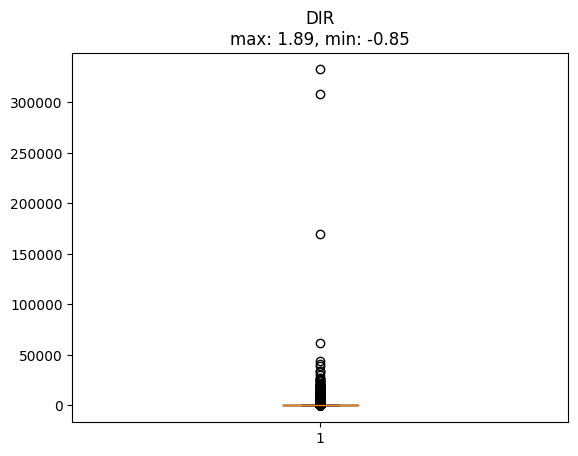

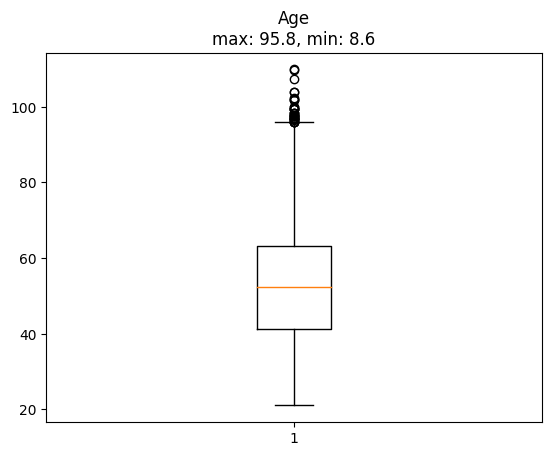

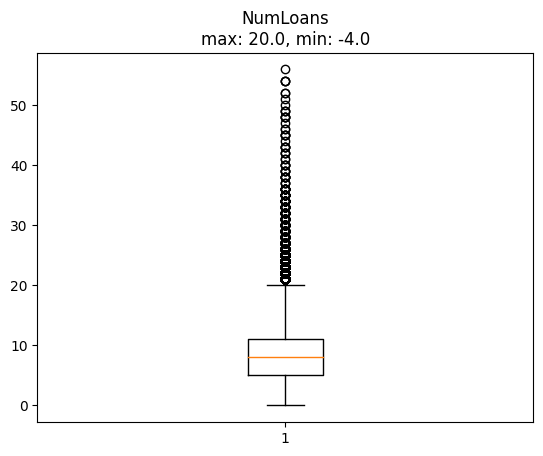

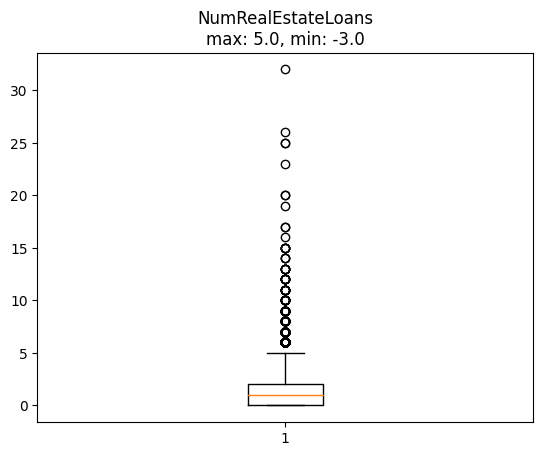

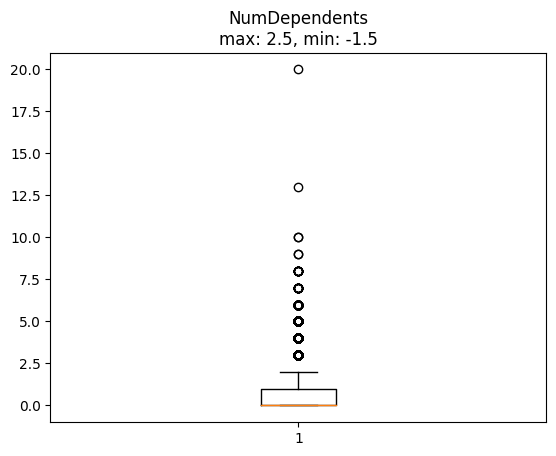

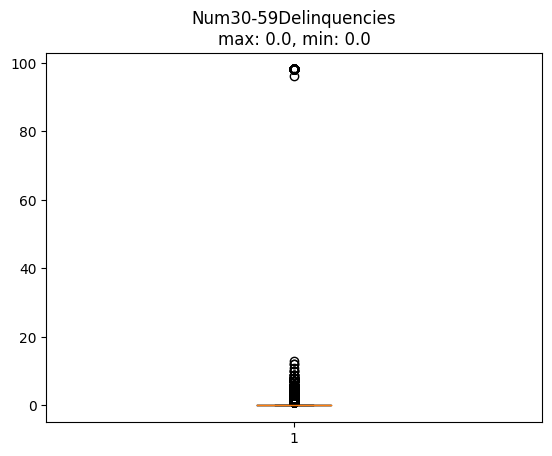

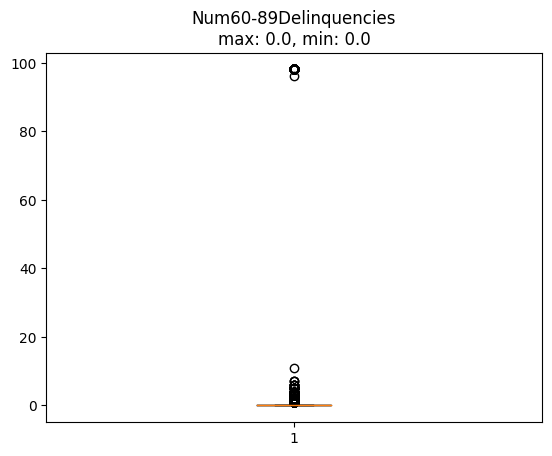

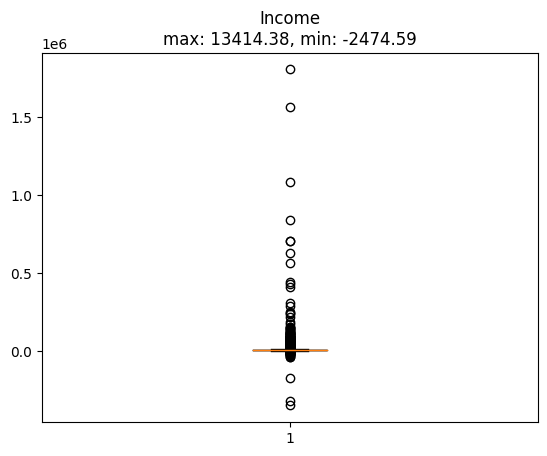

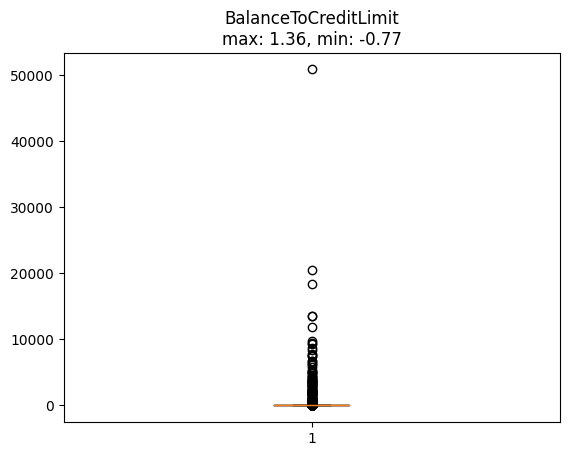

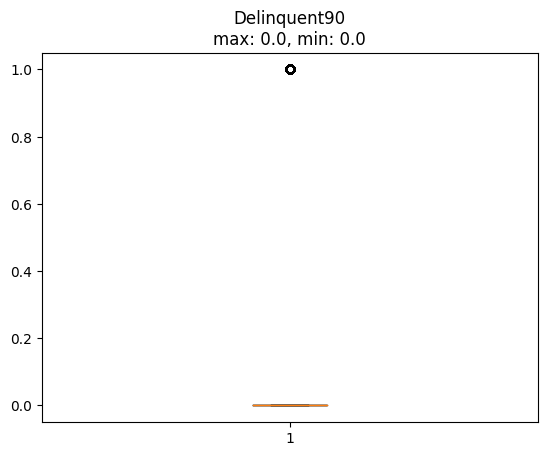

In [13]:
for column in train_df.columns:
    # будем сразу рассчитывать статистически "правильные" max и min
    IQR = np.quantile(train_df[column], .75) - np.quantile(train_df[column], .25)
    stats_max, stats_min = 1.5 * IQR + np.quantile(train_df[column], .75), \
            np.quantile(train_df[column], .25) - 1.5 * IQR
    
    plt.boxplot(train_df[column])
    plt.title(f"{column}\nmax: {round(stats_max, 2)}, min: {round(stats_min, 2)}")
    plt.show();

Попробуем проанализировать результаты. Однозначно нет выбросов в признаке Delinquent90, поскольку он бинарный.
В атрибутах, названия которых начинаются с Num, присутствуют отрицательные значения, хотя по всем показателям это должны быть натуральные числа. 
Посмотрим, сколько аномальных значений среди признаков.

In [14]:
for column in train_df.columns:
    IQR = np.quantile(train_df[column], .75) - np.quantile(train_df[column], .25)
    stats_max, stats_min = 1.5 * IQR + np.quantile(train_df[column], .75), \
            np.quantile(train_df[column], .25) - 1.5 * IQR
    
    print(f"{column}\nбольшие: {len(train_df[train_df[column] > stats_max])}; маленькие: {len(train_df[train_df[column] < stats_min])}\n")

DIR
большие: 15608; маленькие: 0

Age
большие: 36; маленькие: 0

NumLoans
большие: 2000; маленькие: 0

NumRealEstateLoans
большие: 426; маленькие: 0

NumDependents
большие: 6518; маленькие: 0

Num30-59Delinquencies
большие: 11988; маленькие: 0

Num60-89Delinquencies
большие: 3839; маленькие: 0

Income
большие: 3960; маленькие: 52

BalanceToCreditLimit
большие: 398; маленькие: 0

Delinquent90
большие: 5013; маленькие: 0



Значения признака age не кажутся такими большими и отклоняющимися сильно, но наблюдается сильный разброс в признаке Income. В этом признаке присутствуют отрицательные значения, вероятно, это валидные значения, которые получаются в тех случаях, когда клиент не имеет дохода, но вынужден тратить. Возможно, такие значения в признаке будут однозначно указывать, что клиент не сможет заплатить через 3 месяца. Однако от слишком высоких значений можно избавиться, к тому же их не так много, ведь основная масса клиентов банка имеет средний доход.

In [15]:
train_df.drop(index=train_df[train_df['Income'] > 13_414].index, inplace=True)
print(train_df.shape)

(71040, 10)


Также очевидно, что в признаке NumDependents нужно избавиться от записей, в которых значение более 7: очевидно, что количество людей на содержании в среднем 5-6. 

In [16]:
train_df.drop(index=train_df[train_df['NumDependents'] >= 7].index, inplace=True)
print(train_df.shape)

(71010, 10)


In [17]:
train_df.columns

Index(['DIR', 'Age', 'NumLoans', 'NumRealEstateLoans', 'NumDependents',
       'Num30-59Delinquencies', 'Num60-89Delinquencies', 'Income',
       'BalanceToCreditLimit', 'Delinquent90'],
      dtype='object')

В признаках, отвечающих за количество рассрочек и займов у клиента, нужно избавиться от значений, которые больше 20. 

In [18]:
train_df.drop(index=train_df[train_df['Num30-59Delinquencies'] >= 20].index, inplace=True)
train_df.drop(index=train_df[train_df['Num60-89Delinquencies'] >= 20].index, inplace=True)
train_df.drop(index=train_df[train_df['NumLoans'] >= 20].index, inplace=True)
print(train_df.shape)

(68637, 10)


Также очень странно выглядит признак DIR, уберём в нём выбросы.

In [19]:
train_df.drop(index=train_df[train_df['DIR'] > 1.89].index, inplace=True)
print(train_df.shape)

(53470, 10)


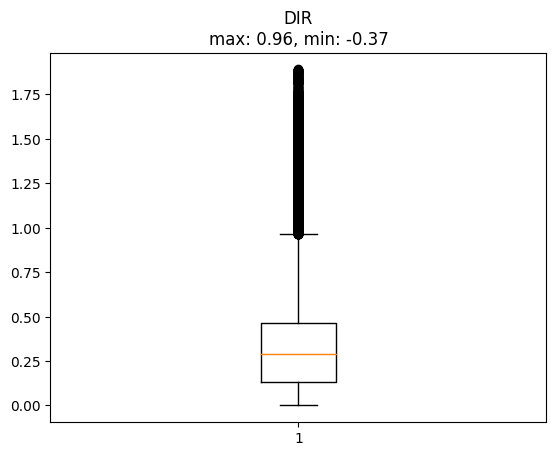

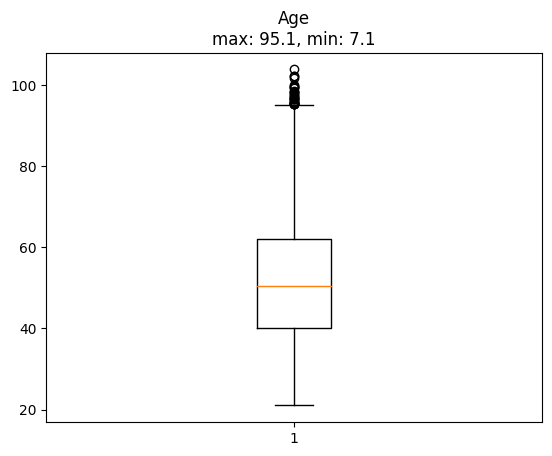

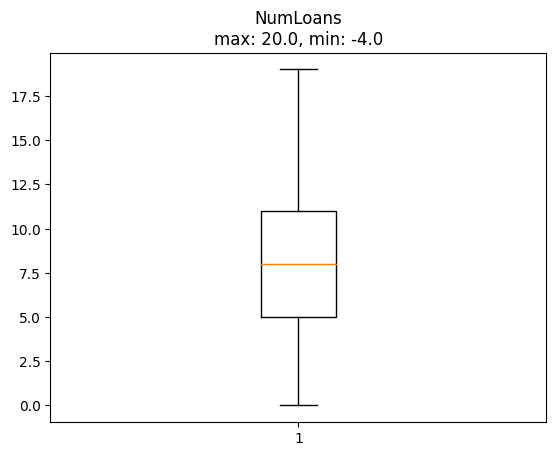

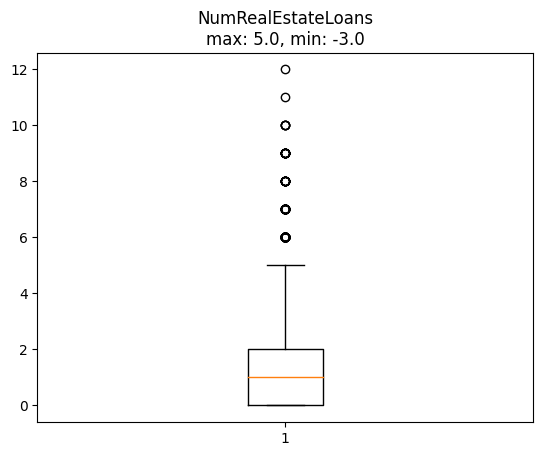

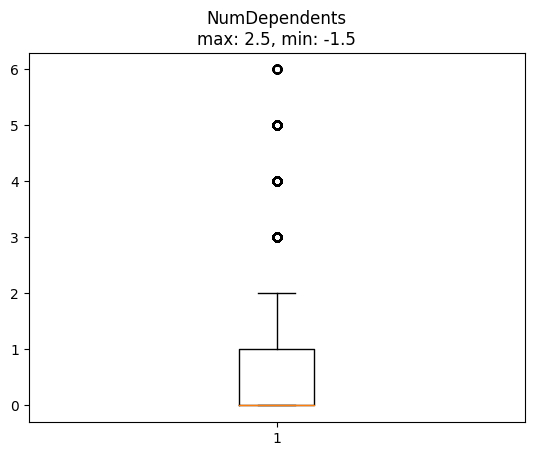

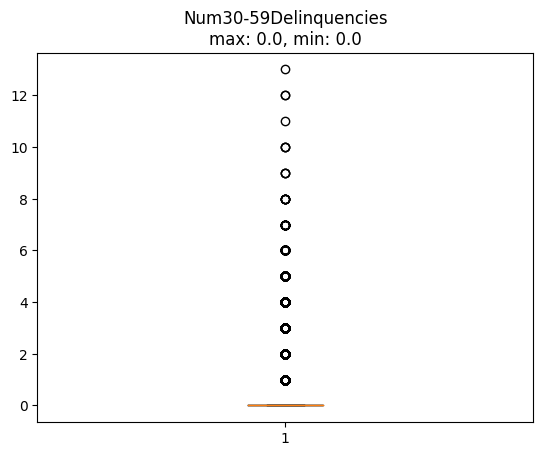

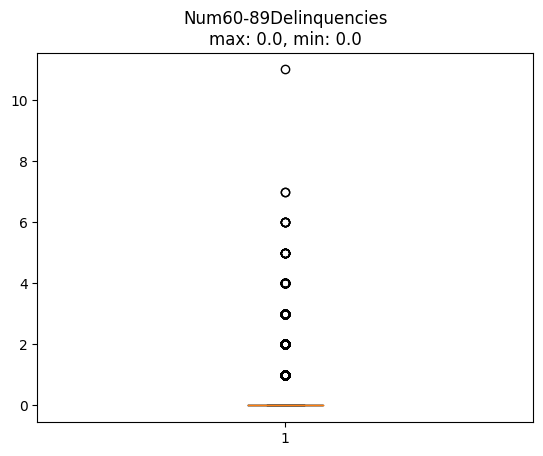

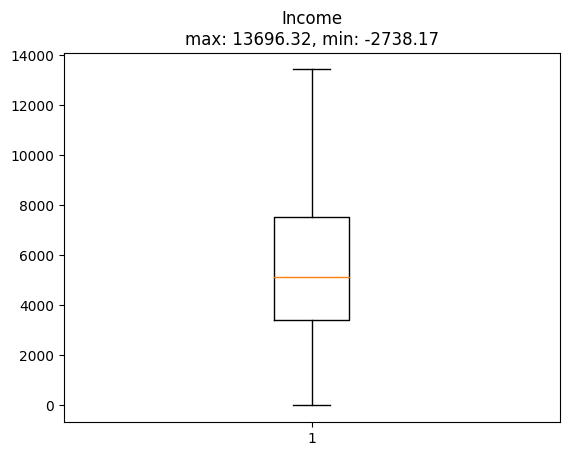

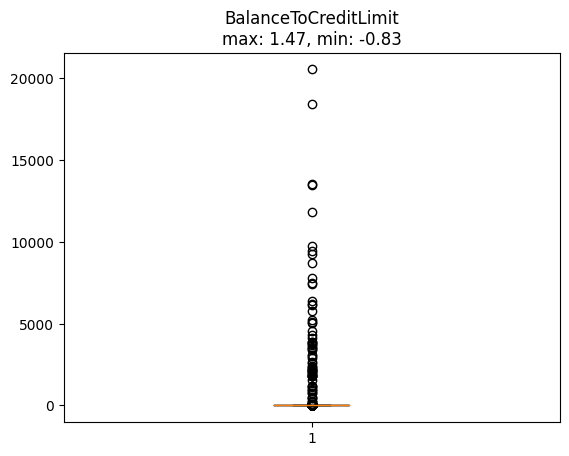

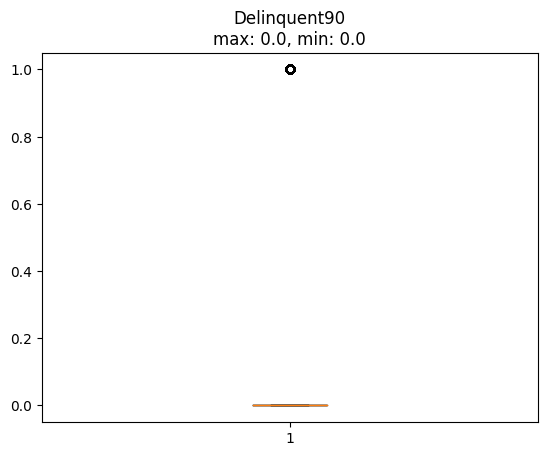

In [20]:
for column in train_df.columns:
    # будем сразу рассчитывать статистически "правильные" max и min
    IQR = np.quantile(train_df[column], .75) - np.quantile(train_df[column], .25)
    stats_max, stats_min = 1.5 * IQR + np.quantile(train_df[column], .75), \
            np.quantile(train_df[column], .25) - 1.5 * IQR
    
    plt.boxplot(train_df[column])
    plt.title(f"{column}\nmax: {round(stats_max, 2)}, min: {round(stats_min, 2)}")
    plt.show();

## Вывод
Данные предобработаны. В ходе предобработки данных были заполнены пропуски в данных, а также обработаны аномальные значения. Данные представлены в численном виде, они готовы для следующего этапа.

In [21]:
train_df.head(5)

,DIR,Age,NumLoans,NumRealEstateLoans,NumDependents,Num30-59Delinquencies,Num60-89Delinquencies,Income,BalanceToCreditLimit,Delinquent90
client_id,,,,,,,,,,
0,0.496289,49.1,13,0,0.0,2,0,5298.360639,0.387028,0
1,0.433567,48.0,9,2,2.0,1,0,6008.056256,0.234679,0
4,0.000000,52.3,1,0,0.0,0,0,2504.613105,1.004350,0
6,0.461193,71.3,9,0,0.0,0,0,3562.767475,0.039618,0
8,0.074518,28.1,10,0,0.0,0,0,5021.722284,0.048213,0


## 1.4 Обучение модели дерева принятия решений
### 1.4.1 Разделение данных на тренировочный и валиадационный наборы

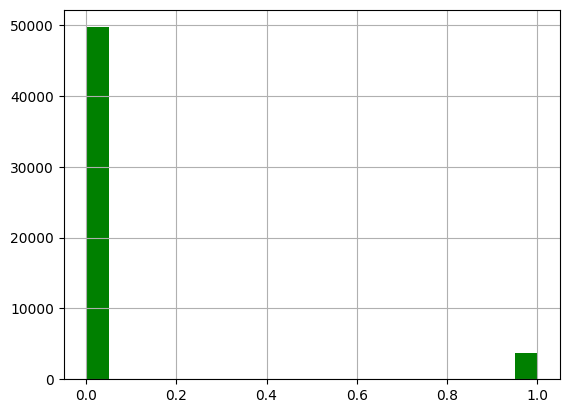

In [22]:
# посмотреть на распределение целевой переменной
train_df['Delinquent90'].hist(bins=20, color='green');

В данных явно наблюдается дисбаланс классов. Чтобы гарантировать, что относительные частоты классов приблизительно сохраняются в каждом цикле обучения и цикле проверки, необходимо установить параметр stratify у функции train_test_split. Разделим данные.

In [23]:
X_train, X_val, y_train, y_val = train_test_split(
    train_df.drop(['Delinquent90'], axis=1), 
    train_df['Delinquent90'], 
    test_size=0.3, 
    random_state=2023, 
    stratify=train_df['Delinquent90']
)

In [24]:
y_train.value_counts(normalize=True)

0    0.929466
1    0.070534
Name: Delinquent90, dtype: float64

In [25]:
y_val.value_counts(normalize=True)

0    0.929431
1    0.070569
Name: Delinquent90, dtype: float64

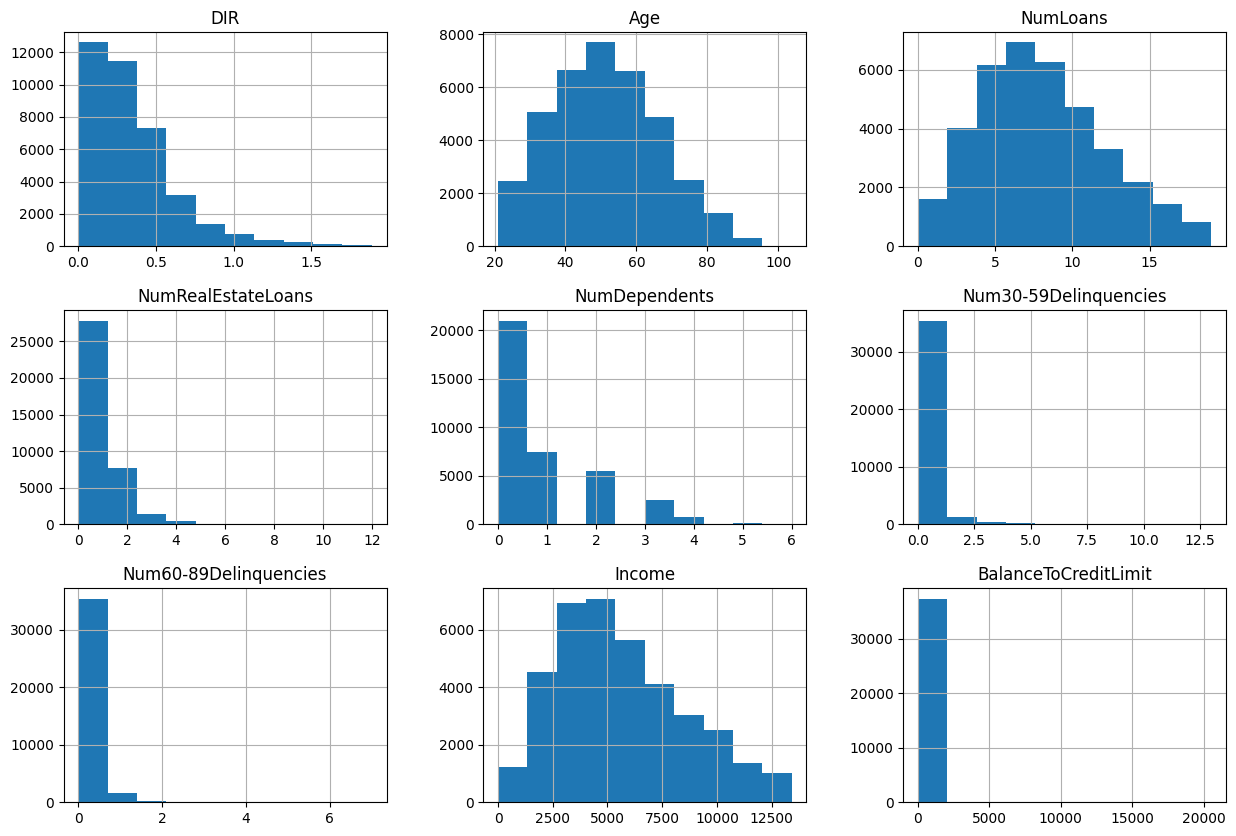

In [26]:
X_train.hist(figsize=(15, 10));

### 1.4.2 Baseline
Наше первая модель будет наивной и основываться на том предположении, что клиенты банка по целевому признаку будут случайно распределяться с тем же соотношением, какое мы наблюдали в тренировочной и валидационной выборках. Посмотрим и оценим эту гипотезу. 

In [27]:
y_naive = np.random.choice([0, 1], size=y_val.shape[0], p=y_train.value_counts(normalize=True))

In [28]:
quality_report(y_naive, y_val)

Accuracy: 0.865
Precision: 0.062
Recall: 0.060
f1_score: 0.061


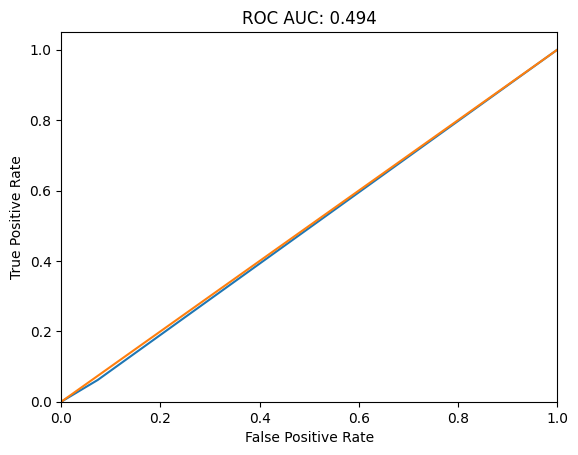

In [29]:
plot_roc_curve(y_naive, y_val)

Несмотря на то, что правильность такой модели очень высокая, фактически наша модель $-$ модель угадывания, к какому классу относится конкретный клиент банка, о чём и сообщает целевая метрика ROC AUC.

### 1.4.3 Дерево решений без настройки параметров

In [36]:
first_tree = DecisionTreeClassifier(max_depth=3, random_state=42)
first_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [37]:
print("Train quality")
quality_report(first_tree.predict(X_train), y_train)

print("\nTest quality")
quality_report(first_tree.predict(X_val), y_val)

Train quality
Accuracy: 0.931
Precision: 0.051
Recall: 0.605
f1_score: 0.094

Test quality
Accuracy: 0.932
Precision: 0.068
Recall: 0.681
f1_score: 0.124


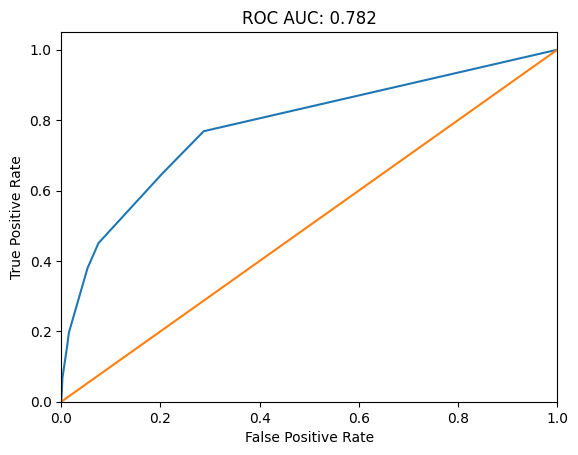

In [38]:
plot_roc_curve(first_tree.predict_proba(X_val)[:, 1], y_val)

Результат гораздо лучше, классификатор на основе дерева принятия решений дал показатель ROC AUC в 78%, при этом я только глубину дерева урезал до 3 уровней.

Модель дерева принятия решений ещё прекрасна тем, что может показать, какие признаки были важны для неё. Визуализируем их.

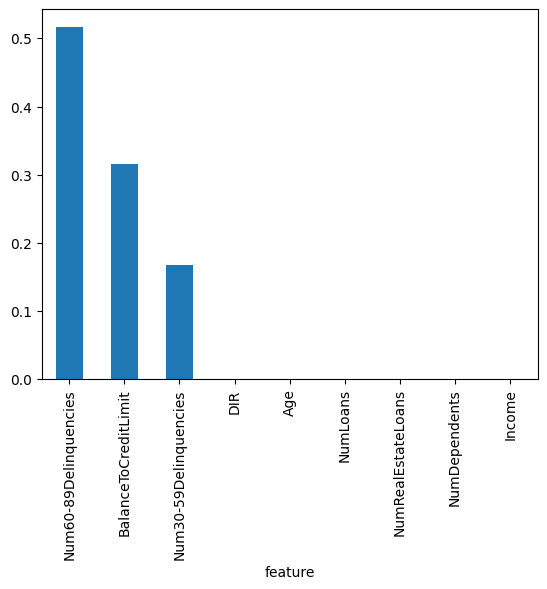

In [40]:
featureImportance = pd.DataFrame({"feature": X_train.columns, 
                                  "importance": first_tree.feature_importances_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind='bar');

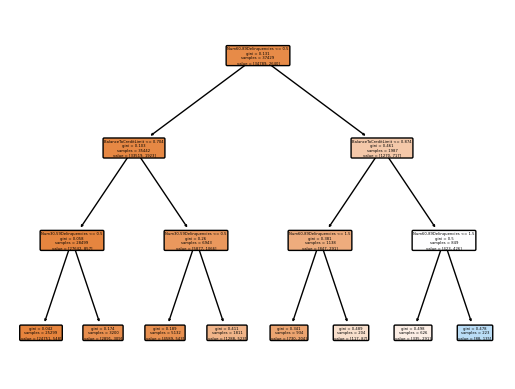

In [43]:
# нарисуем получившееся дерево
plot_tree(first_tree,
         feature_names=X_train.columns,
          rounded=True, filled=True);

### 1.4.4 Дерево решений с настройкой параметров с помощью GridSearch
Получившаяся модель хороша, но её можно попробовать улучшить. Потюним параметры.

In [44]:
tree_params = {
               'max_depth': list(range(3,11)), 
               'min_samples_leaf': list(range(3,11)),
               'class_weight': [None, 'balanced']
}

locally_best_tree = GridSearchCV(DecisionTreeClassifier(random_state=42), 
                                 tree_params, 
                                 verbose=True, n_jobs=-1, cv=5,
                                scoring='roc_auc')
locally_best_tree.fit(X_train, y_train)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_leaf': [3, 4, 5, 6, 7, 8, 9, 10]},
             scoring='roc_auc', verbose=True)

In [45]:
locally_best_tree.best_params_, round(locally_best_tree.best_score_, 3)

({'class_weight': None, 'max_depth': 6, 'min_samples_leaf': 8}, 0.826)

In [47]:
quality_report(locally_best_tree.predict(X_val), y_val)

Accuracy: 0.931
Precision: 0.091
Recall: 0.589
f1_score: 0.158


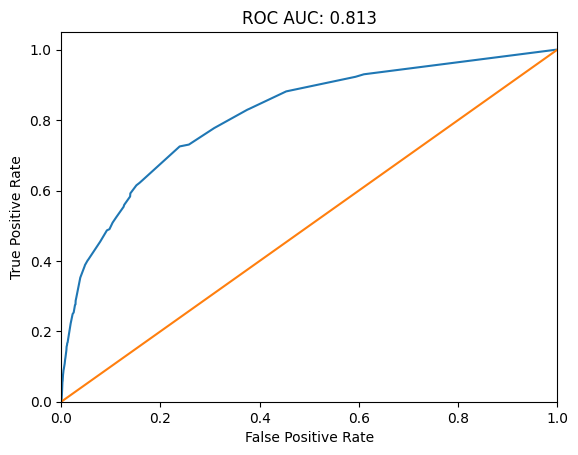

In [48]:
plot_roc_curve(locally_best_tree.predict_proba(X_val)[:, 1], y_val)

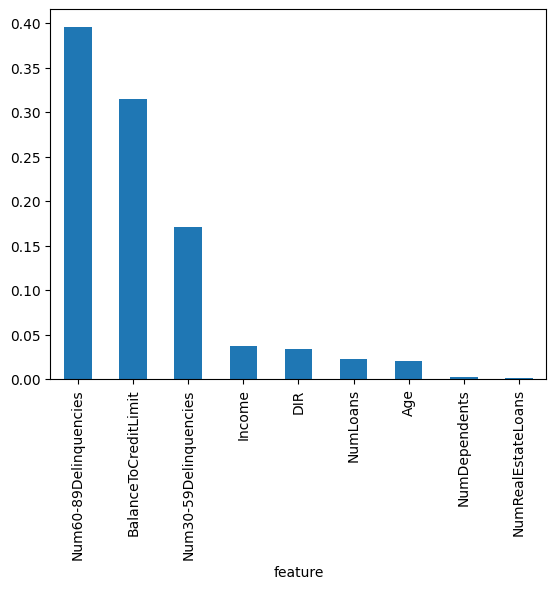

In [50]:
featureImportance = pd.DataFrame({"feature": X_train.columns, 
                                  "importance": locally_best_tree.best_estimator_.feature_importances_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind='bar');

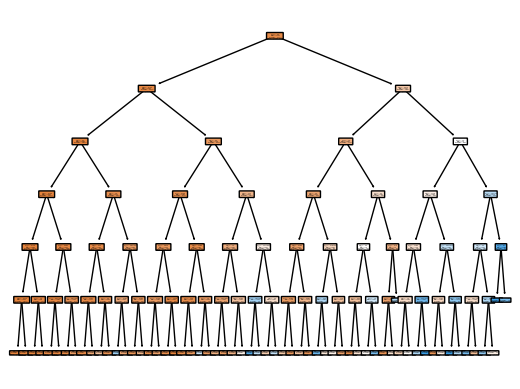

In [52]:
plot_tree(locally_best_tree.best_estimator_,
         rounded=True,
         filled=True);

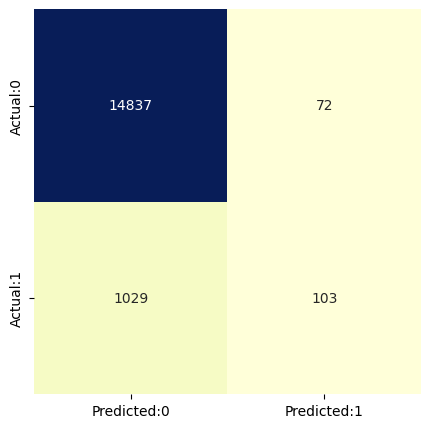

In [53]:
cm = confusion_matrix(y_val, locally_best_tree.predict(X_val))
conf_matrix = pd.DataFrame(data = cm, columns = ['Predicted:0','Predicted:1'], index=['Actual:0','Actual:1'])
plt.figure(figsize = (5,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu", cbar=False);

## 2. Вырастим лес

1. Генерирую 1 000 поднаборов обучающего набора, каждый из которых содержит 100 случайных образцов.

In [55]:
from sklearn.model_selection import ShuffleSplit

# генерирую 1 000 поднаборов обучающего набора, каждый из которых содержит 100 случайных образцов
n_trees = 1000
n_instances = 100

mini_sets = []

rs = ShuffleSplit(n_splits=n_trees, test_size=len(X_train) - n_instances, random_state=42)
for mini_train_index, mini_test_index in rs.split(X_train):
    X_mini_train = X_train.iloc[mini_train_index]
    y_mini_train = y_train.iloc[mini_train_index]
    mini_sets.append((X_mini_train, y_mini_train))

In [58]:
from sklearn.base import clone

# создаю 1 000 деревьев с наилучшими значениями гиперпараметров
forest = [clone(locally_best_tree.best_estimator_) for _ in range(n_trees)]

accuracy_scores = []

# прохожу по каждому из деревьев и даю ему свой поднабор данных
for tree, (X_mini_train, y_mini_train) in zip(forest, mini_sets):
    tree.fit(X_mini_train, y_mini_train)
    
    y_pred = tree.predict(X_val) # вырабатываю прогноз
    accuracy_scores.append(accuracy_score(y_val, y_pred))

# средняя оценка правильности 1 000 деревьев
np.mean(accuracy_scores)

0.9204605074496601

In [59]:
Y_pred = np.empty([n_trees, len(X_val)], dtype=np.uint8)
# собрать предсказания с 1 000 деревьев
for tree_index, tree in enumerate(forest):
    Y_pred[tree_index] = tree.predict(X_val)

In [63]:
from scipy.stats import mode
# найти самое частое предсказание
y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)

In [65]:
quality_report(y_val, y_pred_majority_votes.reshape([-1]))

Accuracy: 0.929
Precision: 0.000
Recall: 0.000
f1_score: 0.000


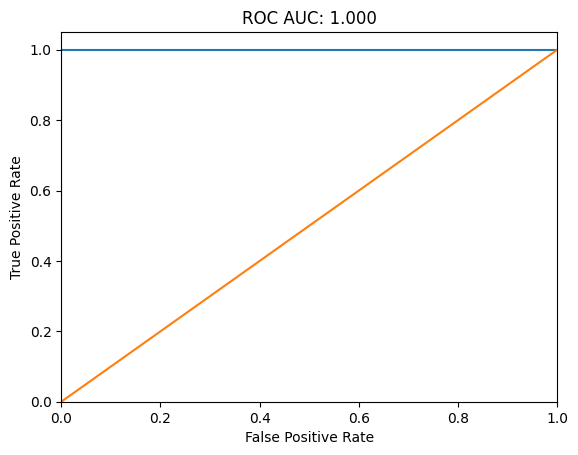

In [66]:
plot_roc_curve(y_val, y_pred_majority_votes.reshape([-1]))